<a href="https://colab.research.google.com/github/ArielFix/DLINtroProject/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import HTML
import subprocess

branch = subprocess.check_output(["git", "rev-parse", "--abbrev-ref", "HEAD"]).decode()[:-1]
HTML('<a href="https://colab.research.google.com/github/ArielFix/DLINtroProject/blob/{branch}/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>'.format(branch=branch))

CalledProcessError: ignored

## Setup Commands

In [ ]:
!git init .
!git remote add origin https://github.com/ArielFix/DLINtroProject.git
!git fetch
!git checkout main

In [22]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import model_selection
from sklearn.metrics import f1_score
import numpy as np
import torch
from torch.utils.data import dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
from google.colab import drive
import os
import sys

drive.mount('/content/gdrive')
train_path = '/content/gdrive/MyDrive/NLP_Project/data/augmented_train.csv'
augumented_data_train_path = '/content/gdrive/MyDrive/NLP_Project/data/augmented_train.csv'
test_path = '/content/gdrive/My Drive/NLP_Project/data/test.csv'
sample_submission_path = '/content/gdrive/MyDrive/NLP_Project/data/sample_submission.csv'

GOOGLE_DRIVE_PATH = '/content/gdrive/MyDrive/NLP_Project'
sys.path.append(GOOGLE_DRIVE_PATH)
print(os.listdir(GOOGLE_DRIVE_PATH))

Mounted at /content/gdrive
['README.md', 'test_augs.py', 'requirements.txt', 'get_roberta_model.py', 'NLP_Project.ipynb', '.gitignore', '.idea', 'pretrained', 'model_b500_lr003_val_acc_0.7525318099195015_original_data.pk', 'augmentations', 'model_overfitdata.pk', 'model_b750_lr003_val_acc_0.749083638787071_augumented_data.pk', 'utilities', 'data', 'roberta', 'NLP_Project Roberta.ipynb']


In [3]:
!echo "This may take a while:"
%pip install -q -r /content/gdrive/MyDrive/NLP_Project/requirements.txt # fill here the path to the requirement file

This may take a while:
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 KB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 88.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 16.0 MB/s eta 0:00:00


In [4]:
augumented_train_df = pd.read_csv(augumented_data_train_path)
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,1,NaN,NaN,Our human_activity are the understanding of th...,1
2,1,NaN,NaN,Our Deeds are the Reason of this # May ALLAH F...,1
3,1,NaN,NaN,Our Deeds are forgive deed the Allah Reason of...,1
4,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1


**A quick look at our data**
Let's look at our data... first, some examples of what is NOT a disaster tweet.

In [5]:
print('\n' .join(map(str, train_df[train_df["target"] == 0]["text"].values[0:5])))


What's up man?
What's upwards human_being?
's  man?
What's up serviceman man?
What's up man?


And some examples of what is a disaster tweet.

In [6]:
print('\n' .join(map(str, train_df[train_df["target"] == 1]["text"].values[0:5])))

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Our human_activity are the understanding of this #earthquake May Allah forgive us all
Our Deeds are the Reason of this # May ALLAH Forgive us all
Our Deeds are forgive deed the Allah Reason of this America #earthquake May ALLAH Forgive us all
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all


The words contained in each tweet are a good indicator of whether they're about a real disaster or not. This is not entirely correct, but it's a great place to start.

We'll use scikit-learn's 'train_test_split' for splitting the train data to train and validation sets for monitoring the model training.

In [7]:
train_df, val_df = model_selection.train_test_split(train_df, test_size=0.15, train_size=0.85)

**Our model**

As we mentioned above, we think the words contained in each tweet are a good indicator of whether they're about a real disaster or not. The presence of particular word (or set of words) in a tweet might link directly to whether or not that tweet is real.

We want to modify [twitter-roberta-sentiment](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment) for the classification task of disaster tweets.
First let's load the pretrained model

In [8]:
from pretrained.get_pretrained_roberta import GetPretrainedRoberta 

roberta = GetPretrainedRoberta() #init pretrained roberta model and tokenizer
roberta.model.modules # Shows model's modules

<bound method Module.modules of RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, 

Now, we want our model output layer to be the results o a sigmoid layer, this sigmoid layer should get only one value from the last linear layer.
We will change the linear layer 'out'proj' with 3 outputs into a sequenc which includes the same input size, output size of 1 and a sigmoid.
Additioanly, we want to fine tune the pretained roberta model with the new output layer so we will freeze the entire model except the 'Classifier' module which includes the last layer.  

In [9]:
from pretrained.modify_roberta import ModifyRoberta

ModifyRoberta.modify_binary_output(roberta.model) #change output layer to linear -> sigmoid
ModifyRoberta.modify_only_train_calssifier(roberta.model) #freeze the parameters except the 'Classifier' module
roberta.model.modules


<bound method Module.modules of RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, 

In [10]:
roberta.model.classifier.out_proj[0].reset_parameters

<bound method Linear.reset_parameters of Linear(in_features=768, out_features=2, bias=True)>

Now we should preprocess and prepare the data for the model training

In [11]:
from utilities.preprocess import Utilities

val_df.dropna(axis=0, inplace=True)
val_df.reset_index(drop=True, inplace=True)
train_df.dropna(axis=0, inplace=True)
train_df.reset_index(drop=True, inplace=True)

train_text, train_target = train_df['text'].to_list(), train_df['target']
Utilities().preprocess_text_list(train_text)
train_data = pd.DataFrame()
train_data['text'], train_data['target'] = train_text, train_df['target']
val_text = val_df['text'].to_list()
Utilities().preprocess_text_list(val_text)
val_data = pd.DataFrame()
val_data['text'], val_data['target'] = val_text, val_df['target']



And let's see how a sample data tokenized by the tokenizer

In [ ]:
roberta.tokenizer(train_data['text'][train_data.index[0:3]].to_list(), return_tensors='pt', padding=True)

{'input_ids': tensor([[    0,   620,  9707,  3521,  2451,    30, 18621,  4742,  2054,     2,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1],
        [    0,  1558,   151,  9593,    25,   886,   668,  8344,   687,  1829,
           268, 34505,  8493,     7,  1871,  1611,     4,   849, 10448,   219,
         17260, 44454,   640,    90,     4,   876,    73,    90,   387,  4429,
           139, 27457, 43820, 44454,   640,    90,     4,   876,    73,  1872,
           428, 42631,   534,  5433, 23858,     2],
        [    0,  1039, 12105,   787, 12105,   787, 12105, 15983, 15983,    99,
           114,    38,   146,     5,   593,  5666,    41,  6978, 11657,    11,
             5,  1437,  2808,    83,  8640,  4154, 28073,  4014,  3411,   448,
             

We can notice that the tokenizer creates two tensors:  
1. 'input_ids' - includes the word indexes from the dictioanry, we can also see that padding uses '1' to equalize the tensor's second dimension length.
2. 'attention_mask' - includes the mask for the 'input_ids' tensor, which includes '1' for actual word in 'input_ids' and '0' for padded values in it.

Now we will verify that our modified model enable to overfit a sample of the training data:

In [ ]:
from roberta.roberta_handle import RobertaHandler as RH

handler = RH()
try_train = handler.train_roberta_model(val_data=train_data[0:15] ,batch_size=15, check_point_path=None, learning_rate=1e-2, num_epoches=30, train_data=train_data[0:15], model=roberta)

====> Epoch: 1 Average train loss: 0.0165, train acc: 0.7143, Average val loss: 0.0315, val acc: 0.7143
====> Epoch: 2 Average train loss: 0.0470, train acc: 1.0000, Average val loss: 0.0116, val acc: 1.0000
====> Epoch: 3 Average train loss: 0.0252, train acc: 0.8182, Average val loss: 0.0213, val acc: 0.8182
====> Epoch: 4 Average train loss: 0.0333, train acc: 0.8182, Average val loss: 0.0248, val acc: 0.8182
====> Epoch: 5 Average train loss: 0.0424, train acc: 0.8182, Average val loss: 0.0180, val acc: 0.8182
====> Epoch: 6 Average train loss: 0.0192, train acc: 1.0000, Average val loss: 0.0108, val acc: 1.0000
====> Epoch: 7 Average train loss: 0.0204, train acc: 1.0000, Average val loss: 0.0085, val acc: 1.0000
====> Epoch: 8 Average train loss: 0.0098, train acc: 0.9412, Average val loss: 0.0121, val acc: 0.9412
====> Epoch: 9 Average train loss: 0.0183, train acc: 0.9412, Average val loss: 0.0143, val acc: 0.9412
====> Epoch: 10 Average train loss: 0.0242, train acc: 0.9412, A

Let's plot the training and validation acuracies and losses

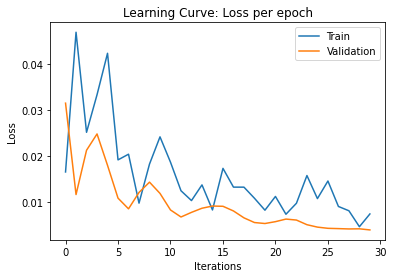

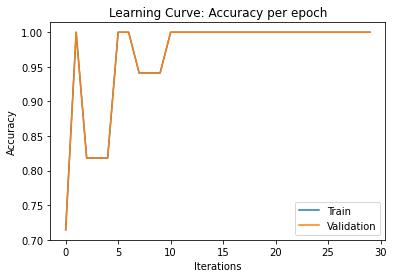

In [ ]:
RH.plot_learning_curve(*try_train)

In [ ]:
roberta.model.save_pretrained('/content/gdrive/My Drive/NLP_Project/model_overfitdata.pk')

It seem that we overfitted well (f1 score of 1) and we are ready for training:

In [ ]:
from pretrained.get_pretrained_roberta import GetPretrainedRoberta 
from pretrained.modify_roberta import ModifyRoberta

roberta_model = GetPretrainedRoberta()
ModifyRoberta.modify_binary_output(roberta_model.model) 
ModifyRoberta.modify_only_train_calssifier(roberta_model.model)

In [ ]:
from roberta.roberta_handle import RobertaHandler as RH

handler = RH()

trained_softmax = handler.train_roberta_model(weight_decay=1e-3 ,val_data=val_data ,batch_size=500, check_point_path=None, learning_rate=1e-3, num_epoches=30, train_data=train_data, model=roberta_model)


====> Epoch: 1 Average train loss: 0.0012, train acc: 0.7034, Average val loss: 0.0011, val acc: 0.7003
====> Epoch: 2 Average train loss: 0.0011, train acc: 0.7165, Average val loss: 0.0010, val acc: 0.7113
====> Epoch: 3 Average train loss: 0.0010, train acc: 0.7282, Average val loss: 0.0010, val acc: 0.7255
====> Epoch: 4 Average train loss: 0.0010, train acc: 0.7352, Average val loss: 0.0010, val acc: 0.7347
====> Epoch: 5 Average train loss: 0.0010, train acc: 0.7369, Average val loss: 0.0010, val acc: 0.7357
====> Epoch: 6 Average train loss: 0.0010, train acc: 0.7389, Average val loss: 0.0009, val acc: 0.7409
====> Epoch: 7 Average train loss: 0.0010, train acc: 0.7474, Average val loss: 0.0009, val acc: 0.7451
====> Epoch: 8 Average train loss: 0.0010, train acc: 0.7405, Average val loss: 0.0009, val acc: 0.7381
====> Epoch: 9 Average train loss: 0.0010, train acc: 0.7520, Average val loss: 0.0009, val acc: 0.7487
====> Epoch: 10 Average train loss: 0.0010, train acc: 0.7531, A

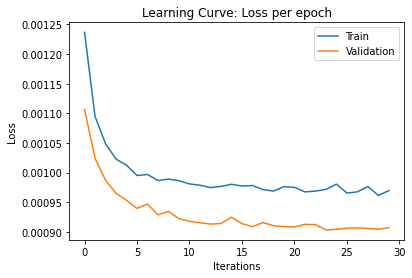

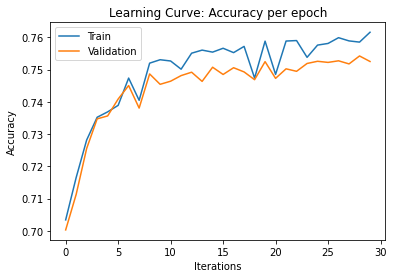

In [ ]:
RH.plot_learning_curve(*trained_softmax)

In [ ]:
roberta_model.model.save_pretrained(f'/content/gdrive/My Drive/NLP_Project/model_b500_lr003_val_acc_{trained_softmax[4][-1]}_original_data.pk')

Now we will try to train a model with augumented data

In [12]:
aug_train_df, aug_val_df = model_selection.train_test_split(train_df, test_size=0.15, train_size=0.85)

aug_val_df.dropna(axis=0, inplace=True)
aug_val_df.reset_index(drop=True, inplace=True)
aug_train_df.dropna(axis=0, inplace=True)
aug_train_df.reset_index(drop=True, inplace=True)

aug_train_text, aug_train_target = aug_train_df['text'].to_list(), aug_train_df['target']
Utilities().preprocess_text_list(aug_train_text)
aug_train_data = pd.DataFrame()
aug_train_data['text'], aug_train_data['target'] = aug_train_text, aug_train_df['target']
aug_val_text = aug_val_df['text'].to_list()
Utilities().preprocess_text_list(aug_val_text)
aug_val_data = pd.DataFrame()
aug_val_data['text'], aug_val_data['target'] = aug_val_text, aug_val_df['target']

In [18]:
from pretrained.get_pretrained_roberta import GetPretrainedRoberta 
from pretrained.modify_roberta import ModifyRoberta

roberta_model_aug_data = GetPretrainedRoberta()
ModifyRoberta.modify_binary_output(roberta_model_aug_data.model) 
ModifyRoberta.modify_only_train_calssifier(roberta_model_aug_data.model)

In [ ]:
from roberta.roberta_handle import RobertaHandler as RH

handler = RH()

trained_aug_data = handler.train_roberta_model(val_data=aug_val_data ,batch_size=1000, check_point_path=None, learning_rate=1e-2, num_epoches=30, train_data=aug_train_data, model=roberta_model_aug_data)


====> Epoch: 1 Average train loss: 0.0006, train acc: 0.7298, Average val loss: 0.0005, val acc: 0.7334
====> Epoch: 2 Average train loss: 0.0005, train acc: 0.7189, Average val loss: 0.0005, val acc: 0.7372
====> Epoch: 3 Average train loss: 0.0005, train acc: 0.7335, Average val loss: 0.0005, val acc: 0.7483
====> Epoch: 4 Average train loss: 0.0005, train acc: 0.7520, Average val loss: 0.0005, val acc: 0.7590
====> Epoch: 5 Average train loss: 0.0005, train acc: 0.7555, Average val loss: 0.0005, val acc: 0.7580
====> Epoch: 6 Average train loss: 0.0005, train acc: 0.7367, Average val loss: 0.0005, val acc: 0.7455
====> Epoch: 7 Average train loss: 0.0005, train acc: 0.7557, Average val loss: 0.0004, val acc: 0.7654
====> Epoch: 8 Average train loss: 0.0005, train acc: 0.7578, Average val loss: 0.0005, val acc: 0.7659
====> Epoch: 9 Average train loss: 0.0005, train acc: 0.7554, Average val loss: 0.0004, val acc: 0.7645
====> Epoch: 10 Average train loss: 0.0005, train acc: 0.7522, A

In [ ]:
RH.plot_learning_curve(*trained_aug_data)

In [ ]:
roberta_model_aug_data.model.save_pretrained(f'/content/gdrive/My Drive/NLP_Project/model_b750_lr003_val_acc_{trained_aug_data[4][-1]}_augumented_data.pk')

As we can see, augumented data changes a lot but it still seems like we can improve our predictions.
let's try to analyse the data, first we will see if there there is any bias

In [35]:
aug_train_data['target'].value_counts(normalize=True)

,text,target,text_count
637,Wreckage 'Conclusively Confirmed' as From MH37...,1,17
1220,Wreckage 'Conclusively Confirmed' as From MH37...,1,17
2541,Wreckage 'Conclusively Confirmed' as From MH37...,1,17
3957,Wreckage 'Conclusively Confirmed' as From MH37...,1,17
4653,Wreckage 'Conclusively Confirmed' as From MH37...,1,17
5619,Wreckage 'Conclusively Confirmed' as From MH37...,1,17
6792,Wreckage 'Conclusively Confirmed' as From MH37...,1,17
8094,Wreckage 'Conclusively Confirmed' as From MH37...,1,17
8416,Wreckage 'Conclusively Confirmed' as From MH37...,1,17
8451,Wreckage 'Conclusively Confirmed' as From MH37...,1,17


We can see above an example of dome duplicated tweed with different labels.  
We can relabel according to the average of labels, it will act like a kind of voting system for the correct label, the tweets with average of 0.5 will be handled manually:

In [ ]:
def add_avg_target_column(df, column_name1, column_name2):
    # Group the DataFrame by the specified column and count the number of rows in each group
    df['avg_target'] = df.groupby(column_name1)[column_name2].transform('mean')
    return df

train_avg = add_avg_target_column(train_counted, 'text', 'target')
val_avg = add_avg_target_column(val_counted, 'text', 'target')

First let's handle the tweets with verage of 0.5:

In [ ]:
manual_decission_train = train_avg.loc[train_avg['mean'] == 0.5]
manual_decission_val = train_avg.loc[val_avg['mean'] == 0.5]

In [ ]:
manual_decission_train.head(len(manual_decission_train))

In [ ]:
manual_decission_val.head(len(manual_decission_val))

In [ ]:
for param in roberta_model2.model.parameters():
  param.requires_grad = True

In [ ]:
trained_softmax2 = handler.train_roberta_model(val_data=val_data ,batch_size=32, check_point_path=None, learning_rate=4e-6, num_epoches=30, train_data=train_data, model=roberta_model2)
RH.plot_learning_curve(*trained_softmax2)

In [ ]:
results = pd.read_csv(sample_submission_path)
results.target = clf.predict(count_vectorizer.transform(test_df["text"]))
results.to_csv("submission.csv", index=False)

In [ ]:
! pip install -q datasets
!pip install evaluate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 7.0 MB/s eta 0:00:00


In [ ]:
from torch.utils.data import Dataset
from datasets import Dataset,DatasetDict #-> Hugging Face

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)


[autoreload of urllib3.packages.six failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 287, in update_class
    old_obj = getattr(old, key)
  File "/usr/local/lib/python3.8/dist-packages/urllib3/packages/six.py", line 97, in __get__
    setattr(obj, self.name, result)  # Invokes __set__.
AttributeError: 'NoneType' object has no attribute 'cStringIO'
]
[autoreload of urllib3.util.ssl_ failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autorelo

In [ ]:
def tokenize_func(x): 
  return roberta.tokenizer(x["text"])

In [ ]:
tokenized_train = train_dataset.map(tokenize_func, batched=True)
tokenized_val = val_dataset.map(tokenize_func, batched=True)

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
tokenized_train = tokenized_train.rename_columns({'target':'labels'})
tokenized_val = tokenized_val.rename_columns({'target':'labels'})

In [ ]:
from transformers import TrainingArguments,Trainer

In [ ]:
import numpy as np
import evaluate

def compute_metrics(eval_preds):
    metric = evaluate.load("f1")
    preds, labels = eval_preds
    return metric.compute(predictions=preds, references=labels)